In [1]:

import os
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import scipy.spatial.distance as dist
import catboost as cbt
import json
from sklearn.metrics import f1_score
import time

import gc
import math
from tqdm import tqdm
from scipy import stats
from sklearn.cluster import KMeans
from six.moves import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

In [2]:
os.listdir(r'H:\compitition\sichuan-fusai\cbt')
submission = pd.read_csv(r'H:\compitition\sichuan\cbt\submit_example.csv')
train = pd.read_csv(r'H:\compitition\sichuan-fusai\cbt/train_user4.csv')
test = pd.read_csv(r'H:\compitition\sichuan-fusai\cbt/test_user4.csv')

In [3]:
data = train.append(test)

In [4]:
data.shape

(3495, 91)

In [5]:
cat_list = [i for i in train.columns if i in ['city_name','county_name','idcard_cnt']]
for i in tqdm(cat_list):
    data['{}_count'.format(i)] = data.groupby(['{}'.format(i)])['ID'].transform('count')
feature_name = [i for i in data.columns if i not in ['ID','Label']]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 272.89it/s]


In [7]:
tr_index = ~data['Label'].isnull()
X_train = data[tr_index][list(set(feature_name))].reset_index(drop=True)
y = data[tr_index]['Label'].reset_index(drop=True).astype(int)
X_test = data[~tr_index][list(set(feature_name))].reset_index(drop=True)
print(X_train.shape,X_test.shape)
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
seeds = [19970412, 2019 * 2 + 1024, 4096, 2018, 1024]
num_model_seed = 5
for model_seed in range(num_model_seed):
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat=np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        print(index)
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        cbt_model = cbt.CatBoostClassifier(iterations=8000,learning_rate=0.08,max_depth=8,verbose=100,
                                       early_stopping_rounds=500,task_type='GPU',eval_metric='AUC',
                                       cat_features=cat_list)
        cbt_model.fit(train_x[feature_name], train_y,eval_set=(test_x[feature_name],test_y))
        gc.collect()    
        oof_cat[test_index] += cbt_model.predict_proba(test_x)[:,1]
        prediction_cat += cbt_model.predict_proba(X_test[feature_name])[:,1]/5   
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
print('score',f1_score(y, np.round(oof)))    

(2045, 92) (1450, 92)
0
0:	learn: 0.9258888	test: 0.9067196	best: 0.9067196 (0)	total: 120ms	remaining: 16m 1s
100:	learn: 0.9998296	test: 0.9739014	best: 0.9740722 (95)	total: 11.3s	remaining: 14m 40s
200:	learn: 1.0000000	test: 0.9771460	best: 0.9772598 (198)	total: 23s	remaining: 14m 52s
300:	learn: 1.0000000	test: 0.9790813	best: 0.9792805 (295)	total: 35.1s	remaining: 14m 57s
400:	learn: 1.0000000	test: 0.9797643	best: 0.9799351 (388)	total: 47s	remaining: 14m 50s
500:	learn: 1.0000000	test: 0.9784836	best: 0.9799351 (388)	total: 58.9s	remaining: 14m 40s
600:	learn: 1.0000000	test: 0.9781136	best: 0.9799351 (388)	total: 1m 10s	remaining: 14m 31s
700:	learn: 1.0000000	test: 0.9777436	best: 0.9799351 (388)	total: 1m 22s	remaining: 14m 19s
800:	learn: 1.0000000	test: 0.9776013	best: 0.9799351 (388)	total: 1m 34s	remaining: 14m 12s
bestTest = 0.9799351096
bestIteration = 388
Shrink model to first 389 iterations.
1
0:	learn: 0.9251797	test: 0.8957764	best: 0.8957764 (0)	total: 122ms	re

500:	learn: 1.0000000	test: 0.9708008	best: 0.9724134 (217)	total: 1m 13s	remaining: 18m 23s
600:	learn: 1.0000000	test: 0.9704841	best: 0.9724134 (217)	total: 1m 28s	remaining: 18m 9s
700:	learn: 1.0000000	test: 0.9704264	best: 0.9724134 (217)	total: 1m 43s	remaining: 17m 56s
bestTest = 0.9724134207
bestIteration = 217
Shrink model to first 218 iterations.
0
0:	learn: 0.9201694	test: 0.8860713	best: 0.8860713 (0)	total: 140ms	remaining: 18m 37s
100:	learn: 0.9996647	test: 0.9739868	best: 0.9739868 (100)	total: 14.6s	remaining: 19m 5s
200:	learn: 1.0000000	test: 0.9785120	best: 0.9785975 (197)	total: 29.3s	remaining: 18m 58s
300:	learn: 1.0000000	test: 0.9781421	best: 0.9791382 (244)	total: 44.2s	remaining: 18m 49s
400:	learn: 1.0000000	test: 0.9775159	best: 0.9791382 (244)	total: 59.2s	remaining: 18m 41s
500:	learn: 1.0000000	test: 0.9774590	best: 0.9791382 (244)	total: 1m 13s	remaining: 18m 27s
600:	learn: 1.0000000	test: 0.9775729	best: 0.9791382 (244)	total: 1m 28s	remaining: 18m 1

1000:	learn: 1.0000000	test: 0.9675757	best: 0.9679788 (563)	total: 1m 58s	remaining: 13m 50s
bestTest = 0.9679788351
bestIteration = 563
Shrink model to first 564 iterations.
4
0:	learn: 0.9320290	test: 0.9031013	best: 0.9031013 (0)	total: 115ms	remaining: 15m 18s
100:	learn: 0.9998963	test: 0.9750626	best: 0.9754082 (99)	total: 12.1s	remaining: 15m 43s
200:	learn: 1.0000000	test: 0.9771072	best: 0.9774815 (146)	total: 24s	remaining: 15m 32s
300:	learn: 1.0000000	test: 0.9784893	best: 0.9787773 (283)	total: 35.9s	remaining: 15m 18s
400:	learn: 1.0000000	test: 0.9775391	best: 0.9787773 (283)	total: 47.7s	remaining: 15m 4s
500:	learn: 1.0000000	test: 0.9775679	best: 0.9787773 (283)	total: 59.5s	remaining: 14m 51s
600:	learn: 1.0000000	test: 0.9782014	best: 0.9787773 (283)	total: 1m 11s	remaining: 14m 38s
700:	learn: 1.0000000	test: 0.9779998	best: 0.9787773 (283)	total: 1m 23s	remaining: 14m 26s
bestTest = 0.978777349
bestIteration = 283
Shrink model to first 284 iterations.
0
0:	learn:

In [8]:
submit = test[['ID']]
sub["label"] = sub["prob"] > round(np.percentile(sub["prob"], threshold), 4)
submit['label'] = (prediction>=0.499).astype(int)  #以0.5为界
submit['label'].replace(0,'FALSE',inplace = True)
submit['label'].replace(1,'True',inplace = True)
submit.rename(columns={'ID':'phone_no_m'})
print(submit['label'].value_counts())
submit.to_csv("submission.csv",index=False)

D:\A\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 92 artists>

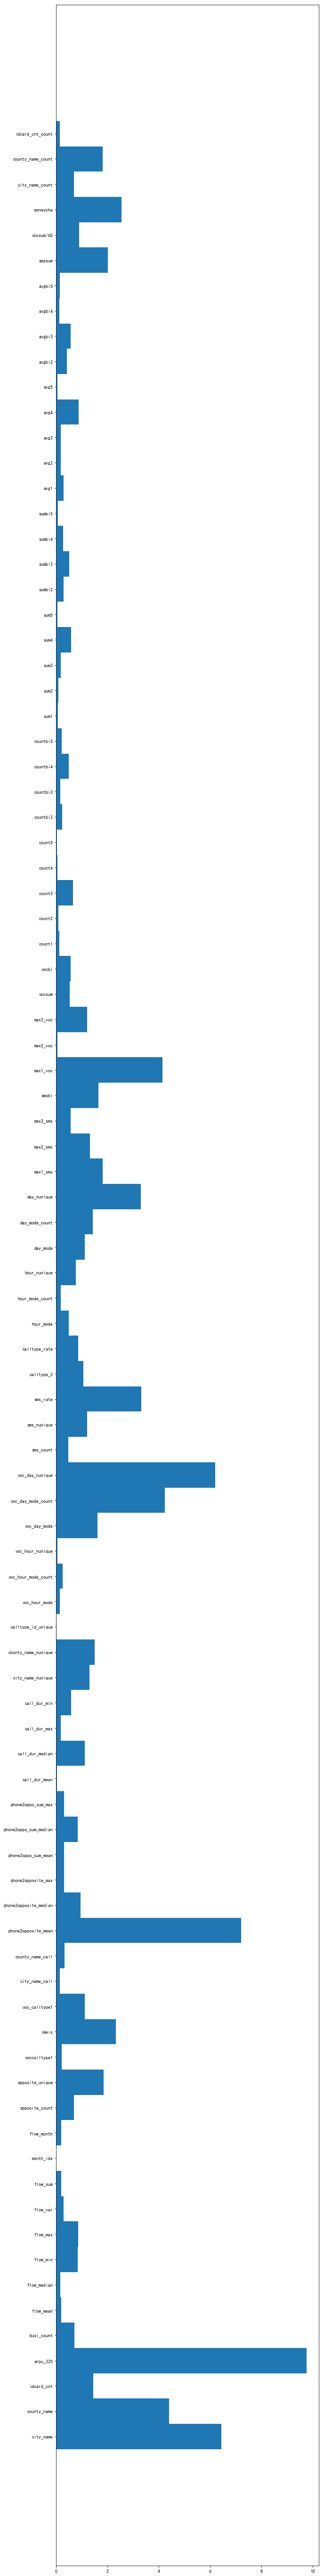

In [9]:
import matplotlib.pyplot as plt 


plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

fea_ = cbt_model.feature_importances_
fea_name = cbt_model.feature_names_
plt.figure(figsize=(10, 100))
plt.barh(fea_name,fea_,height =1)

In [12]:

submission['Label'] = prediction

submission.to_csv("submission0416cat.csv",index=False)